# Imports

notes:

scipy==1.12
gensim==4.3.1
numpy==1.22


In [2]:
%pip install -r requirements.txt

# Todo: NEED TO ADD SPELL CHECK

Note: you may need to restart the kernel to use updated packages.


In [3]:
#import kagglehub
import os
import shutil
import pandas as pd

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [5]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os


from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora


from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import pkg_resources
from symspellpy.symspellpy import SymSpell, Verbosity

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

import ssl
import certifi
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text  # This is necessary for ELMo
import numpy as np

import ssl
import certifi
import tensorflow_hub as hub

from collections import Counter


/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import pickle
import glob
import numpy as np

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



# 1. EDA and Data Wrangling 


## Load


In [ ]:
# download the data
# Download latest version
path = kagglehub.dataset_download("subhajeetdas/hate-comment")

print("Path to dataset files:", path)

destination_path = "/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data"
os.makedirs(destination_path, exist_ok=True)

# move downloaded files
for file in os.listdir(path):
    shutil.move(os.path.join(path, file), destination_path)

print("Dataset moved to:", destination_path)

In [9]:
data = pd.read_csv('/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/hate.csv')

In [10]:
data.drop(columns=['0'], inplace=True)


In [11]:
data

comment label
0                                    dalits are lowlives     N
1                 gay people are a burden to our society     N
2                                  Arabs are not welcome     N
3      I'm not saying we should actually eliminate he...     N
4                           bananas are for black people     N
...                                                  ...   ...
41139                     Indian culture is so backwards     N
41140  Women don't want equality, they just want to b...     N
41141                                         fuck covid     P
41142                           This computer is garbage     P
41143                 The only good Muslim is a dead one     N

[41144 rows x 2 columns]

/var/folders/zv/4f9cw9vs6tjbvz5bh2k07w_40000gn/T/ipykernel_85442/633069675.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Hateful", "Non Hateful", "Other"])


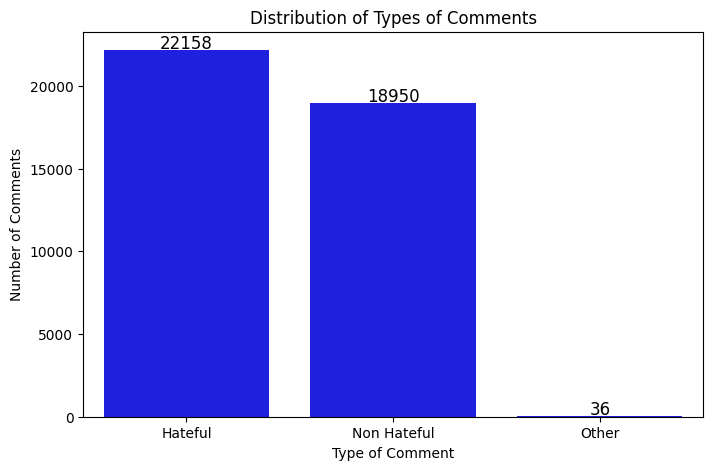

In [16]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data['label'].value_counts(), color="Blue")

# Labels and title
plt.xlabel("Type of Comment")
plt.ylabel("Number of Comments")
plt.title("Distribution of Types of Comments")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='Black', 
                xytext=(0, 5), textcoords='offset points')

# Customize x-axis labels
ax.set_xticklabels(["Hateful", "Non Hateful", "Other"])


# Show plot
plt.show()

## Data distribution

In [17]:
filtered_df = data[data['label'] == 'N']
filtered_df

comment label
0                                    dalits are lowlives     N
1                 gay people are a burden to our society     N
2                                  Arabs are not welcome     N
3      I'm not saying we should actually eliminate he...     N
4                           bananas are for black people     N
...                                                  ...   ...
41136         Mandatory masks should be for mozzies only     N
41137                                Women are dishonest     N
41139                     Indian culture is so backwards     N
41140  Women don't want equality, they just want to b...     N
41143                 The only good Muslim is a dead one     N

[22158 rows x 2 columns]

N: gay people are a burden to our society

P(non hate): 
- this drink sucks, it's awful
- fuck covid

N(hate):
- gay people are a burden to our society
- Arabs are not welcome



## Cleaning

In [18]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

def clean_comment(comment): 

    suggestions = sym_spell.lookup_compound(comment, max_edit_distance=2)

    for suggestion in suggestions:
        #print(suggestion.term)
        tokens = suggestion.term

    #split document into individual words
    tokens=tokens.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))

    # # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]

    # # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]

    # # filter out short tokens
    # tokens = [word for word in tokens if len(word) > 4]

    #lowercase all words
    tokens = [word.lower() for word in tokens]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]    

    # word stemming    
    ps=PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]

    #print(tokens)
    return tokens


In [19]:
# Apply the clean_comment function to the 'comment' column
data['cleaned_comment'] = data['comment'].apply(clean_comment)

# Compute comment lengths after cleaning
data['comment_length'] = data['cleaned_comment'].apply(len)

# Get statistics
average_length = data['comment_length'].mean()
max_length = data['comment_length'].max()
min_length = data['comment_length'].min()

# Display results
print(f"Average Length: {average_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")


Average Length: 12.594764728757534
Max Length: 212
Min Length: 0


In [20]:

# Compute comment lengths

data['comment_length'] = data['comment'].apply(len)

# Get statistics
average_length = data['comment_length'].mean()
max_length = data['comment_length'].max()
min_length = data['comment_length'].min()

# Display results
print(f"Average Length: {average_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")


data['comment_length_clean'] = data['cleaned_comment'].apply(len)

# Get statistics
average_length = data['comment_length_clean'].mean()
max_length = data['comment_length_clean'].max()
min_length = data['comment_length_clean'].min()

# Display results
print(f"Average Length: {average_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")



Average Length: 134.29642232160217
Max Length: 2374
Min Length: 4
Average Length: 12.594764728757534
Max Length: 212
Min Length: 0


In [21]:
# want to stitch back together the cleaned_comment
data['cleaned_comment_string'] = data['cleaned_comment'].apply(lambda x: " ".join(x))

In [22]:
data

comment label  \
0                                    dalits are lowlives     N   
1                 gay people are a burden to our society     N   
2                                  Arabs are not welcome     N   
3      I'm not saying we should actually eliminate he...     N   
4                           bananas are for black people     N   
...                                                  ...   ...   
41139                     Indian culture is so backwards     N   
41140  Women don't want equality, they just want to b...     N   
41141                                         fuck covid     P   
41142                           This computer is garbage     P   
41143                 The only good Muslim is a dead one     N   

                                         cleaned_comment  comment_length  \
0                                        [davit, lowlif]              19   
1                          [gay, peopl, burden, societi]              38   
2                                         [arab, welcom]              21   
3      [im, say, actual, elimin, herb, wish, natur, b...              93   
4                                 [banana, black, peopl]              28   
...                                                  ...             ...   
41139                         [indian, cultur, backward]              30   
41140            [women, dont, want, equal, want, charg]              57   
41141                                      [fuck, covid]              10   
41142                                   [comput, garbag]              24   
41143                          [good, muslim, dead, one]              34   

       comment_length_clean                             cleaned_comment_string  
0                         2                                       davit lowlif  
1                         4                           gay peopl burden societi  
2                         2                                        arab welcom  
3                         9  im say actual elimin herb wish natur becam ext...  
4                         3                                 banana black peopl  
...                     ...                                                ...  
41139                     3                             indian cultur backward  
41140                     6                   women dont want equal want charg  
41141                     2                                         fuck covid  
41142                     2                                      comput garbag  
41143                     4                               good muslim dead one  

[41144 rows x 6 columns]

In [23]:
data.to_csv('./data/hate_cleaned.csv', index=False)

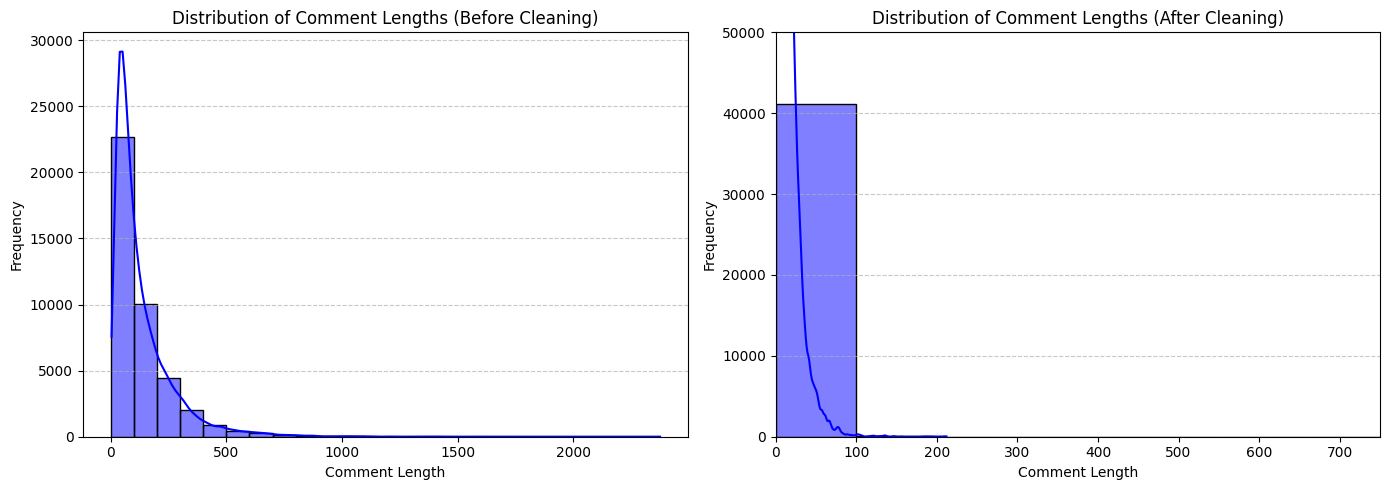

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# specify bins
bins = range(0, 2001, 100)  

# first hist
sns.histplot(data['comment_length'], bins=bins, kde=True, color='blue', ax=axes[0])
axes[0].set_xlabel("Comment Length")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Comment Lengths (Before Cleaning)")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# second hist
sns.histplot(data['comment_length_clean'], bins=bins, kde=True, color='blue', ax=axes[1])
axes[1].set_xlabel("Comment Length")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Comment Lengths (After Cleaning)")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.xlim(0, 750)
plt.ylim(0,50000)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## Words

In [25]:
data

comment label  \
0                                    dalits are lowlives     N   
1                 gay people are a burden to our society     N   
2                                  Arabs are not welcome     N   
3      I'm not saying we should actually eliminate he...     N   
4                           bananas are for black people     N   
...                                                  ...   ...   
41139                     Indian culture is so backwards     N   
41140  Women don't want equality, they just want to b...     N   
41141                                         fuck covid     P   
41142                           This computer is garbage     P   
41143                 The only good Muslim is a dead one     N   

                                         cleaned_comment  comment_length  \
0                                        [davit, lowlif]              19   
1                          [gay, peopl, burden, societi]              38   
2                                         [arab, welcom]              21   
3      [im, say, actual, elimin, herb, wish, natur, b...              93   
4                                 [banana, black, peopl]              28   
...                                                  ...             ...   
41139                         [indian, cultur, backward]              30   
41140            [women, dont, want, equal, want, charg]              57   
41141                                      [fuck, covid]              10   
41142                                   [comput, garbag]              24   
41143                          [good, muslim, dead, one]              34   

       comment_length_clean                             cleaned_comment_string  
0                         2                                       davit lowlif  
1                         4                           gay peopl burden societi  
2                         2                                        arab welcom  
3                         9  im say actual elimin herb wish natur becam ext...  
4                         3                                 banana black peopl  
...                     ...                                                ...  
41139                     3                             indian cultur backward  
41140                     6                   women dont want equal want charg  
41141                     2                                         fuck covid  
41142                     2                                      comput garbag  
41143                     4                               good muslim dead one  

[41144 rows x 6 columns]

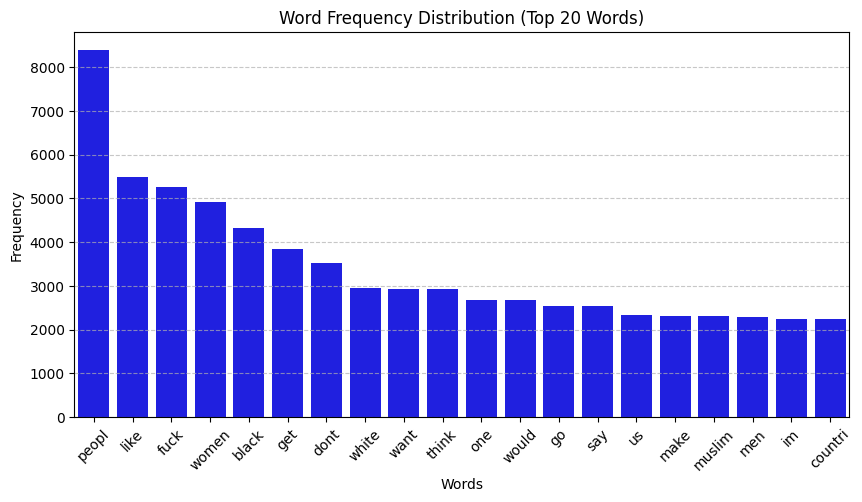

In [ ]:
# figure out the word count
filtered_words = [word for sublist in data['cleaned_comment'] for word in sublist]

# Count word frequencies
word_counts = Counter(filtered_words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Sort by frequency
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)
word_freq_df = word_freq_df.iloc[:20]

# Plot 
plt.figure(figsize=(10, 5))
sns.barplot(x=word_freq_df['word'], y=word_freq_df['count'], color='blue')

# Labels 
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Top 20 Words)")
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


# Clustering and Word Embeddings

## Clustering

In [130]:

"""
    Clusters word embeddings using KMeans with both PCA and t-sne dimension reduction

    Args:
        embeddings (np.array): Word embeddings (n_samples, n_features).
        n_clusters (int): Number of clusters for KMeans.

    Returns:
        dict: Cluster labels for KMeans 
"""

def cluster_embeddings(title, embeddings, n_clusters=2):

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(embeddings)

    clusters = kmeans.fit_predict(embeddings)

    # Create df
    data['Cluster'] = clusters
    cluster_df = data[['Cluster', 'label', 'cleaned_comment']]

    # dimension reduction: TSNE
    reducer = TSNE(n_components=2, random_state=42, init = 'random')
    reduced_embeddings_tsne = reducer.fit_transform(embeddings)

    # dimension reduction: PCA
    reducer = PCA(n_components=2, random_state=42)
    reduced_embeddings_pca = reducer.fit_transform(embeddings)
    
    if (title == 'TFIDF') :
        fig, axes = plt.subplots(1, 3, figsize=(12, 5))

        sns.scatterplot(x=reduced_embeddings_tsne[:, 0], y=reduced_embeddings_tsne[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0])
        axes[0].set_title(f"{title}: KMeans with tsne")

        sns.scatterplot(x=reduced_embeddings_pca[:, 0], y=reduced_embeddings_pca[:, 1], hue=kmeans_labels, palette="coolwarm", ax=axes[1])
        axes[1].set_title(f"{title}: KMeans with pca")

        plt.show()

        return cluster_df


    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[2])
    axes[2].set_title(f"{title}: KMeans No Reduction")

    sns.scatterplot(x=reduced_embeddings_tsne[:, 0], y=reduced_embeddings_tsne[:, 1], hue=kmeans_labels, palette="viridis", ax=axes[0])
    axes[0].set_title(f"{title}: KMeans with tsne")

    sns.scatterplot(x=reduced_embeddings_pca[:, 0], y=reduced_embeddings_pca[:, 1], hue=kmeans_labels, palette="coolwarm", ax=axes[1])
    axes[1].set_title(f"{title}: KMeans with pca")

    plt.show()

    return cluster_df




# 2. word emebeddings:
 - Word2Vec
 - GloVe
 - Elmo
 - Bert
 - TF-IDF
 

 Probably:
- make the max length 200 based on the histogram
- use word2vec
- TF-IDF
- work on seeing how elmo/other things work
- spell check?


## TF-IDF


In [35]:
Tfidf=TfidfVectorizer(ngram_range=(1,1))
TFIDF_embeddings=Tfidf.fit_transform(data['cleaned_comment_string'].tolist())     

tfidf_matrix_df=pd.DataFrame(TFIDF_embeddings.toarray(), columns=Tfidf.get_feature_names_out(), index=data['label'].tolist())

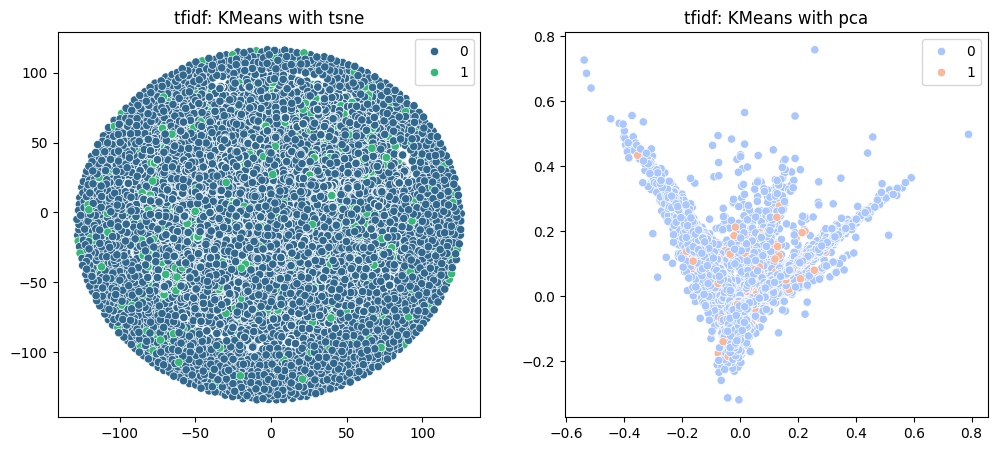

{'kmeans_labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}

In [81]:
cluster_embeddings("tfidf", TFIDF_embeddings, n_clusters=2)

In [99]:
k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_embeddings)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names_out()
Dictionary={'Doc Name':data['label'], 'Cluster':clusters,  'Text': data['cleaned_comment_string']}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles


Top terms per cluster:
Cluster 0:
 corona
 viru
 chines
 real
 isnt
 fuck
 die
 peopl
 rather
 near
Cluster 0 titles: N, N, N, N, N, N, N, N, P, N, P, N, N, N, N, P, P, N, N, N, P, P, N, P, P, P, P, P, N, P, N, P, P, N, N, P, P, N, P, N, P, P, P, P, P, P, P, P, N, P, N, P, N, N, P, P, P, N, P, P, P, N, P, N, P, N, P, N, P, N, N, P, P, P, P, P, P, P, N, P, N, P, P, P, P, P, P, N, P, N, N, P, N, N, N, P, P, N, P, N, P, N, P, N, P, N, P, N, P, N, P, P, N, P, N, P, N, N, P, P, P, P, P, P, N, N, P, P, P, N, N, P, P, N, N, P, N, P, P, P, N, N, P, P, N, P, P, N, N, N, N, N, P, N, N, P, N, P, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, P, N, P, P, N, N, P, P, P, P, P, N, N, P, N, P, P, N, P, P, N, N, N, N, N, P, P, N, N, P, N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, P, N, P, P, N, P, N, P, N, P, N, P, P, N, N, P, N, N, P, N, P, N, N, P, N, N, N, N, N, N, N, N, N, N, N, N, N, N, P, P, P, P, P, P, N, 

## Doc2Vec

In [37]:
# set up documents
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['cleaned_comment'])]
model = Doc2Vec(documents, vector_size=50, window=2, min_count=1, workers=4)

# Train the model
model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4, epochs=20)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

# embeddings
doc2vec_embeddings = np.array([model.dv[i] for i in range(len(documents))])
            

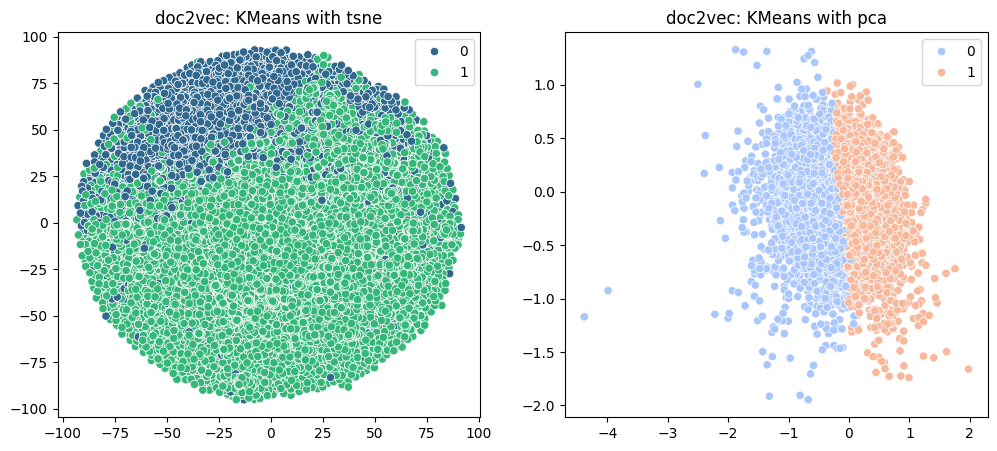

{'kmeans_labels': array([1, 1, 1, ..., 1, 1, 1], dtype=int32)}

In [80]:
cluster_embeddings("tfidf", TFIDF_embeddings, n_clusters=2)

## Word2Vec

In [39]:
# Tokenize comments (assuming data['cleaned_comment'] contains lists of list of words)
tokenized_comments = data['cleaned_comment']

# Train  model 
w2v_model = Word2Vec(sentences=tokenized_comments, vector_size=100, window=5, min_count=1, workers=4)

# Function to compute sentence vector by averaging word vectors
def get_sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Convert all comments into vectors
word2vec_embeddings = np.array([get_sentence_vector(comment, w2v_model) for comment in tokenized_comments])



In [96]:
# Explore the word clusters

# Apply K-Means clustering
k = 5  # Number of clusters
km = KMeans(n_clusters=k, random_state=89)
clusters = km.fit_predict(word2vec_embeddings)

# Create df
data['Cluster'] = clusters
cluster_df = data[['Cluster', 'label', 'cleaned_comment']]

cluster_df

Cluster label                                    cleaned_comment
0            4     N                                    [davit, lowlif]
1            3     N                      [gay, peopl, burden, societi]
2            0     N                                     [arab, welcom]
3            1     N  [im, say, actual, elimin, herb, wish, natur, b...
4            3     N                             [banana, black, peopl]
...        ...   ...                                                ...
41139        0     N                         [indian, cultur, backward]
41140        3     N            [women, dont, want, equal, want, charg]
41141        2     P                                      [fuck, covid]
41142        4     P                                   [comput, garbag]
41143        1     N                          [good, muslim, dead, one]

[41144 rows x 3 columns]

In [97]:
cluster_df

Cluster label                                    cleaned_comment
0            4     N                                    [davit, lowlif]
1            3     N                      [gay, peopl, burden, societi]
2            0     N                                     [arab, welcom]
3            1     N  [im, say, actual, elimin, herb, wish, natur, b...
4            3     N                             [banana, black, peopl]
...        ...   ...                                                ...
41139        0     N                         [indian, cultur, backward]
41140        3     N            [women, dont, want, equal, want, charg]
41141        2     P                                      [fuck, covid]
41142        4     P                                   [comput, garbag]
41143        1     N                          [good, muslim, dead, one]

[41144 rows x 3 columns]

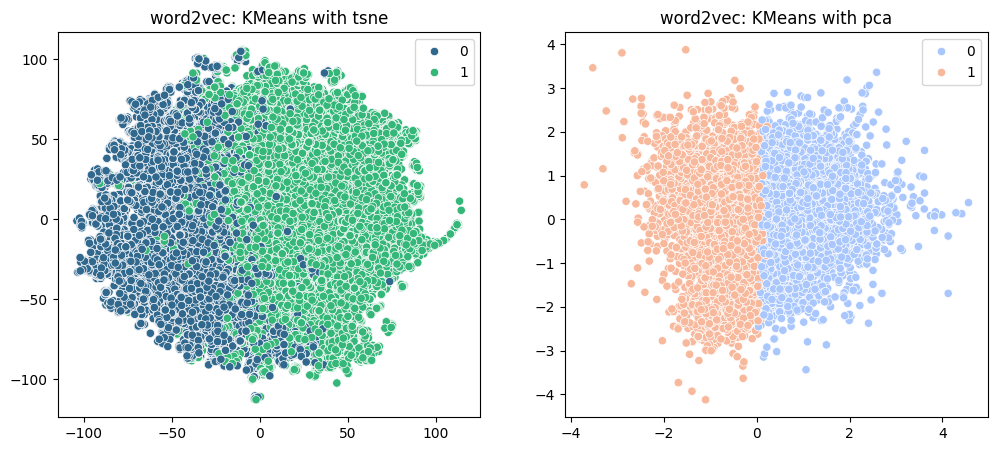

{'kmeans_labels': array([1, 0, 1, ..., 1, 1, 1], dtype=int32)}

In [79]:
cluster_embeddings("word2vec", word2vec_embeddings, n_clusters=2)

## BERT


In [42]:

# Load pre-trained BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast & efficient

# Convert comments to BERT embeddings
bert_embeddings = bert_model.encode(data['cleaned_comment_string'].tolist(), show_progress_bar=True)

# Normalize embeddings
bert_embeddings = StandardScaler().fit_transform(bert_embeddings)


Batches: 100%|██████████| 1286/1286 [01:17<00:00, 16.70it/s]


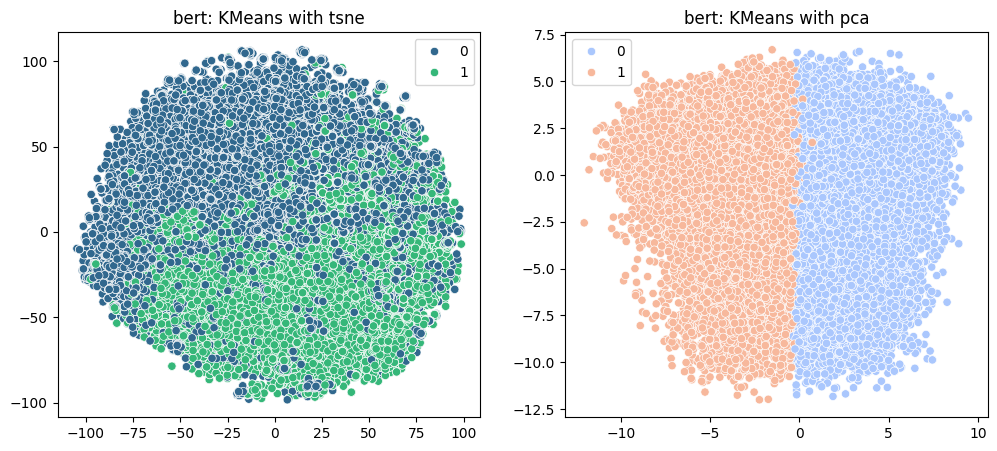

{'kmeans_labels': array([0, 1, 1, ..., 0, 0, 0], dtype=int32)}

In [78]:
cluster_embeddings("bert", bert_embeddings, n_clusters=2)
cluster_embeddings("word2vec", word2vec_embeddings, n_clusters=2)
cluster_embeddings("doc2vec",doc2vec_embeddings, n_clusters=2)
cluster_embeddings("tfidf", TFIDF_embeddings, n_clusters=2)

## Elmo

See the elmo.ipynb notebook for the elmo embeddings. Google colab GPU were used and saved intermediately

In [44]:
#  In GOOGLE COLAB

In [ ]:
import pickle

# Save embeddings to a pickle file in Google Drive
file = '/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/Data_Results/elmo_embeddings_5000.pkl'

with open(file, 'rb') as f:
    elmo_embeddings = pickle.load(f)



In [60]:
# Average over tokens to get a single vector per comment
reduced_embeddings = elmo_embeddings.mean(axis=1)


Shape of reduced embeddings: (999, 1024)


In [49]:
def load_and_concatenate_pickles(file_pattern):
    all_embeddings = []
    
    # Find all pickle files matching the pattern
    file_paths = glob.glob(file_pattern)
    
    # Load multiple batches
    for file in file_paths:
        with open(file, 'rb') as f:
            elmo_embeddings = pickle.load(f)
            
            # Reduce each sample to a single vector by averaging over tokens
            reduced_embeddings = elmo_embeddings.mean(axis=1)

            # add to list
            all_embeddings.append(reduced_embeddings)
    
    # Concatenate into a single array
    concatenated_embeddings = np.concatenate(all_embeddings, axis=0)
    return concatenated_embeddings

# Example usage
file_pattern = '/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/Data_Results_New_4/*.pkl'
elmo_embeddings = load_and_concatenate_pickles(file_pattern)


In [50]:
elmo_embeddings.shape

(41144, 1024)

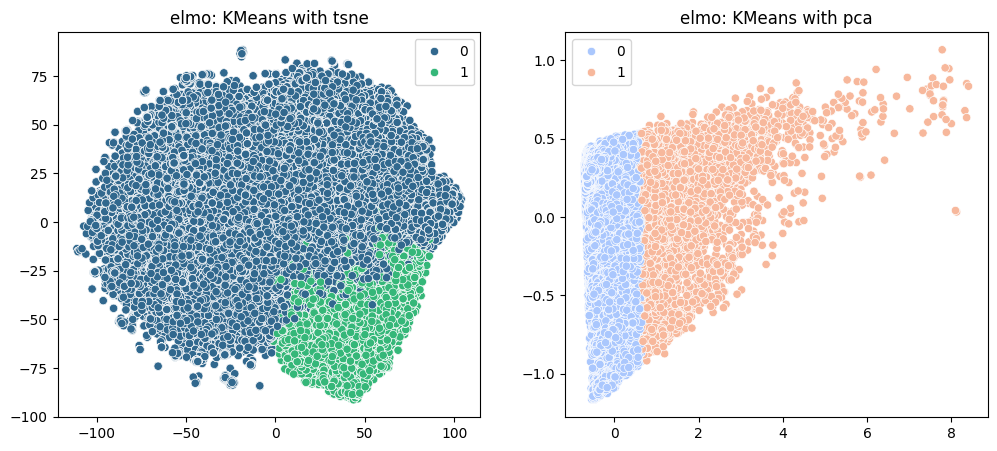

{'kmeans_labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}

In [82]:
cluster_embeddings("elmo", elmo_embeddings, n_clusters=2)

# Cluster

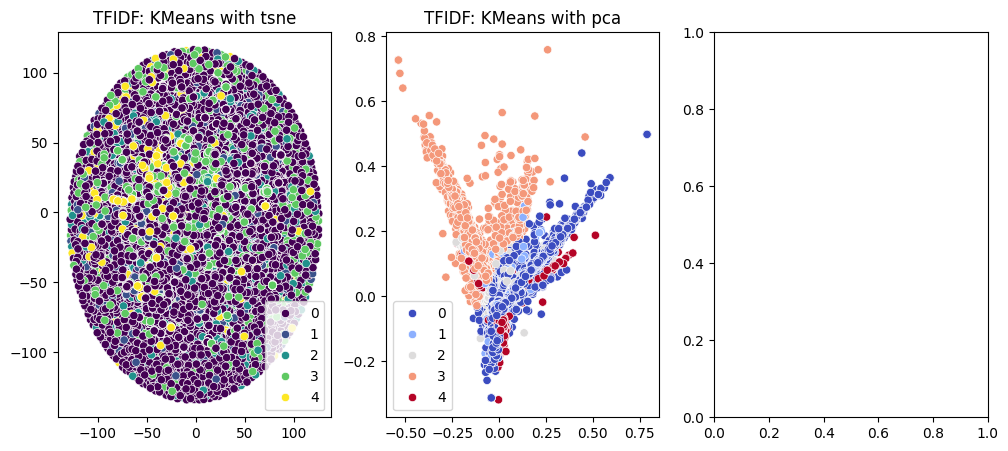

In [131]:
tfidf_cluster_df = cluster_embeddings("TFIDF", TFIDF_embeddings, n_clusters=n)

In [121]:
tfidf_matrix_df

aah  aaron   ab  aba  abaca  abandon  abba  abbess  abbi  abbrevi  ...  \
N   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   
N   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   
N   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   
N   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   
N   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   
..  ...    ...  ...  ...    ...      ...   ...     ...   ...      ...  ...   
N   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   
N   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   
P   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   
P   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   
N   0.0    0.0  0.0  0.0    0.0      0.0   0.0     0.0   0.0      0.0  ...   

    zipper  zodiac  zoe  zombi  zone  zoo  zoom  zoophilia  zulu  zzz  
N      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  
N      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  
N      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  
N      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  
N      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  
..     ...     ...  ...    ...   ...  ...   ...        ...   ...  ...  
N      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  
N      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  
P      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  
P      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  
N      0.0     0.0  0.0    0.0   0.0  0.0   0.0        0.0   0.0  0.0  

[41144 rows x 12676 columns]

In [ ]:
n = 5
elmo_cluster_df = cluster_embeddings("elmo", elmo_embeddings, n_clusters=n)
bert_cluster_df = cluster_embeddings("bert", bert_embeddings, n_clusters=n)
word2vec_cluster_df = cluster_embeddings("word2vec", word2vec_embeddings, n_clusters=n)
doc2vec_cluster_df = cluster_embeddings("doc2vec",doc2vec_embeddings, n_clusters=n)

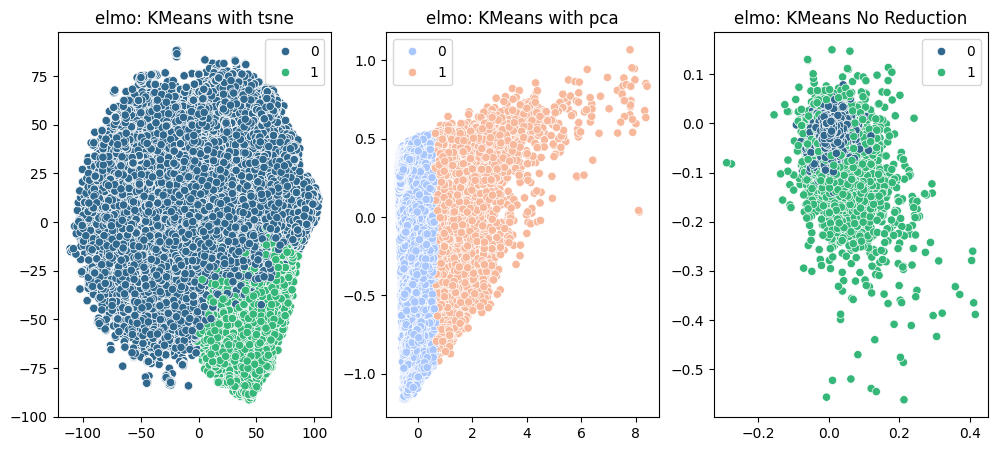

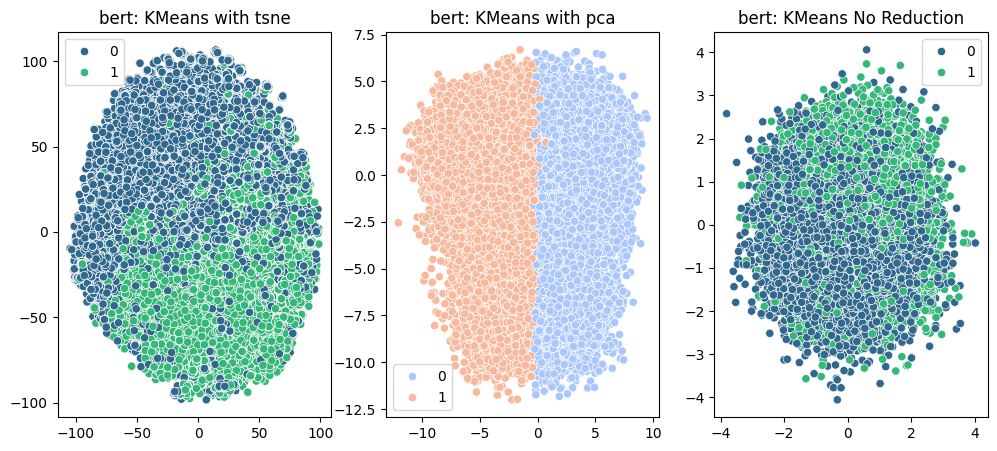

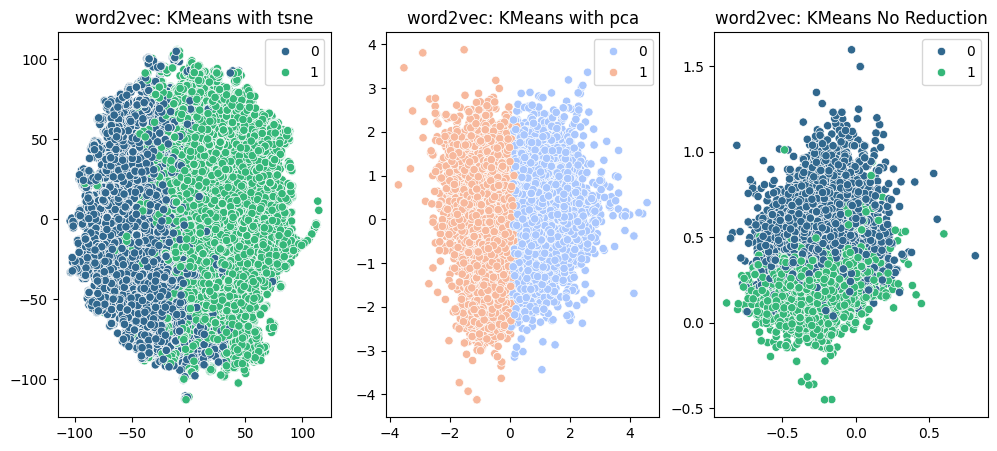

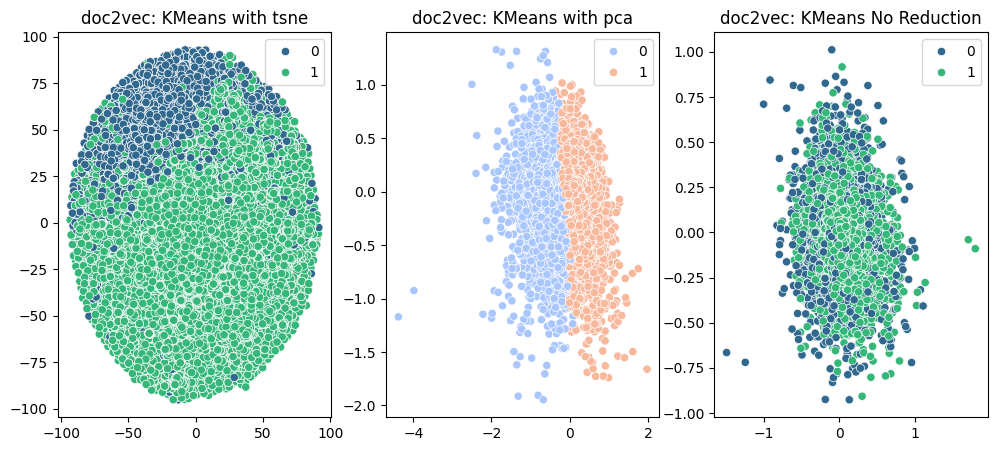

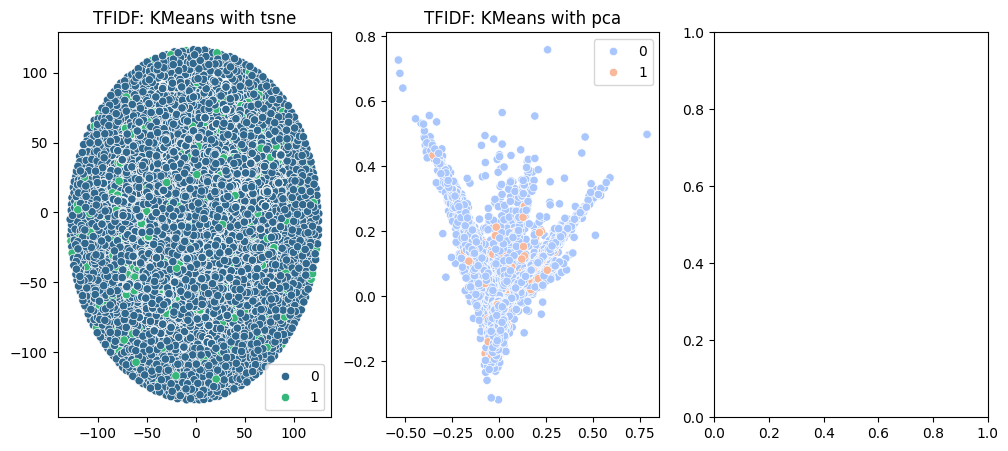

In [133]:
n = 2
elmo_cluster_df = cluster_embeddings("elmo", elmo_embeddings, n_clusters=n)
bert_cluster_df = cluster_embeddings("bert", bert_embeddings, n_clusters=n)
word2vec_cluster_df = cluster_embeddings("word2vec", word2vec_embeddings, n_clusters=n)
doc2vec_cluster_df = cluster_embeddings("doc2vec",doc2vec_embeddings, n_clusters=n)
tfidf_cluster_df = cluster_embeddings("TFIDF",TFIDF_embeddings, n_clusters=n)

# 3. Classify:

In [107]:
def convert_labels(label):
    if label == 'N':
        return 1
    else:
        return 0

def classification_model(embedding_name, X, y):

    # Split into training and testing sets
    y = y.apply(convert_labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    plt.figure(figsize=(10, 8))

    # dict of models tested
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "kNN": KNeighborsClassifier(n_neighbors=5),
        "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42)
    }

    results = {}
    plt.figure(figsize=(8, 6))
    
    # loop over each model
    for name, model in models.items():
        
        # fit the model
        model.fit(X_train, y_train)

        # predict
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
        # assessment scores
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        results[name] = {
            'accuracy': acc,
            'auc': auc,
            'f1_score': f1,
            'fpr': fpr,
            'tpr': tpr
        }
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
        print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

    # Find the best model based on AUC
    best_model = max(results, key=lambda x: results[x]['auc'])
    best_fpr = results[best_model]['fpr']
    best_tpr = results[best_model]['tpr']
    best_f1 = results[best_model]['f1_score']
    
    print(f"\n{embedding_name}: Best Model: {best_model} (AUC = {results[best_model]['auc']:.4f})")

    # Plot ROC curves
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.title(f"{embedding_name}: ROC Curves: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Return best model name, F1 score, FPR, and TPR
    return best_model, auc, best_f1, best_fpr, best_tpr


Random Forest - Accuracy: 0.6138, AUC: 0.6787, F1: 0.6518
Gradient Boosting - Accuracy: 0.6606, AUC: 0.7011, F1: 0.6734
Logistic Regression - Accuracy: 0.6759, AUC: 0.7467, F1: 0.7029
kNN - Accuracy: 0.5219, AUC: 0.5110, F1: 0.6363
Decision Tree - Accuracy: 0.5643, AUC: 0.5769, F1: 0.7052

TFIDF: Best Model: Logistic Regression (AUC = 0.7467)


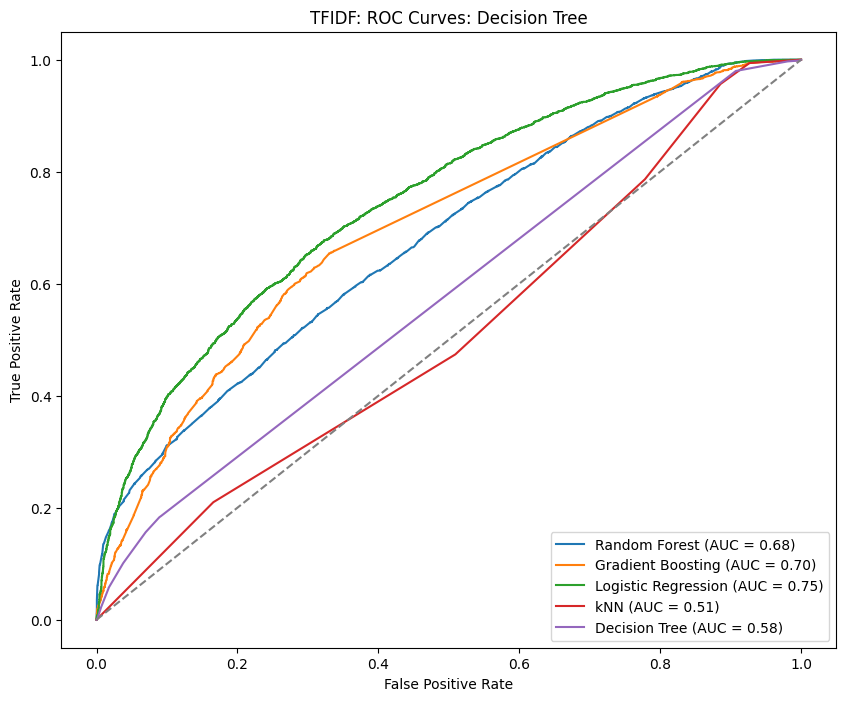

Random Forest - Accuracy: 0.5574, AUC: 0.6059, F1: 0.6087
Gradient Boosting - Accuracy: 0.6044, AUC: 0.6517, F1: 0.6562
Logistic Regression - Accuracy: 0.5914, AUC: 0.6328, F1: 0.6741
kNN - Accuracy: 0.5410, AUC: 0.5773, F1: 0.5821
Decision Tree - Accuracy: 0.5781, AUC: 0.6054, F1: 0.6383

doc2vec: Best Model: Gradient Boosting (AUC = 0.6517)


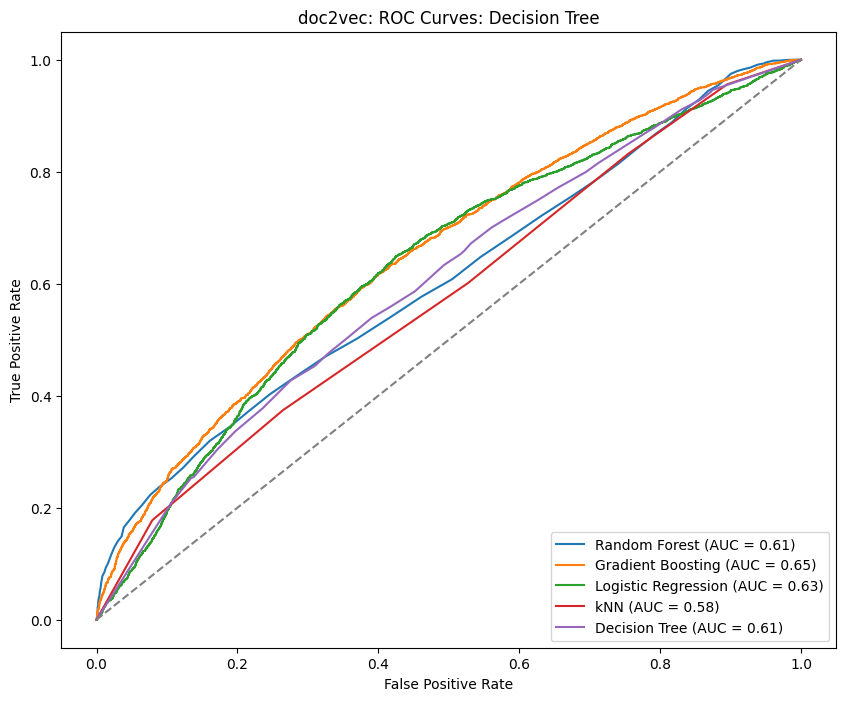

Random Forest - Accuracy: 0.5636, AUC: 0.6136, F1: 0.6147
Gradient Boosting - Accuracy: 0.6159, AUC: 0.6658, F1: 0.6735
Logistic Regression - Accuracy: 0.6134, AUC: 0.6648, F1: 0.6634
kNN - Accuracy: 0.5460, AUC: 0.5828, F1: 0.5885
Decision Tree - Accuracy: 0.5763, AUC: 0.6114, F1: 0.5780

word2vec: Best Model: Gradient Boosting (AUC = 0.6658)


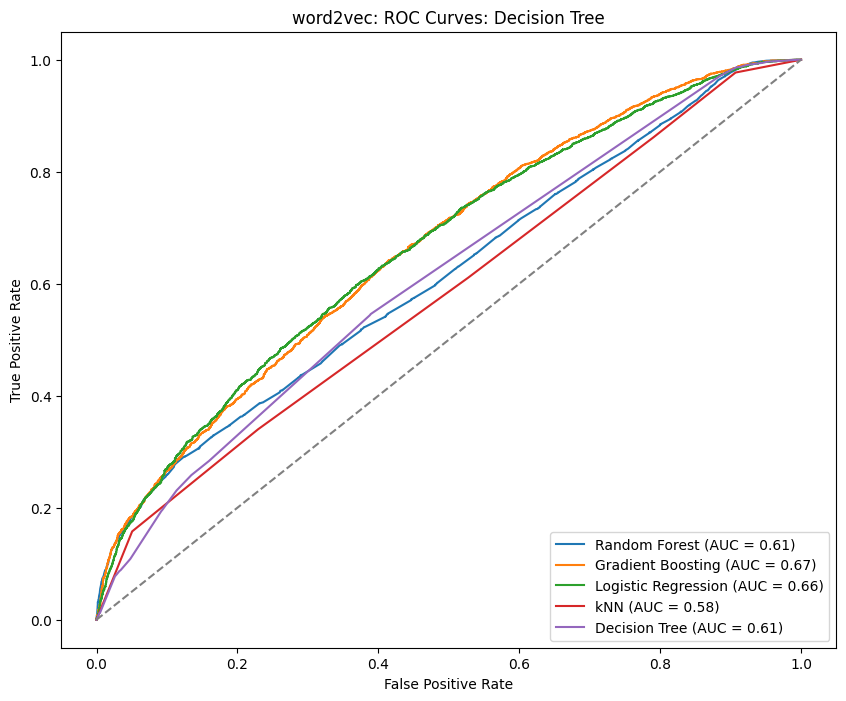

Random Forest - Accuracy: 0.5968, AUC: 0.6318, F1: 0.6509
Gradient Boosting - Accuracy: 0.6445, AUC: 0.6976, F1: 0.6947
Logistic Regression - Accuracy: 0.6571, AUC: 0.7104, F1: 0.6947
kNN - Accuracy: 0.5795, AUC: 0.6313, F1: 0.6318
Decision Tree - Accuracy: 0.5763, AUC: 0.6081, F1: 0.6497

bert: Best Model: Logistic Regression (AUC = 0.7104)


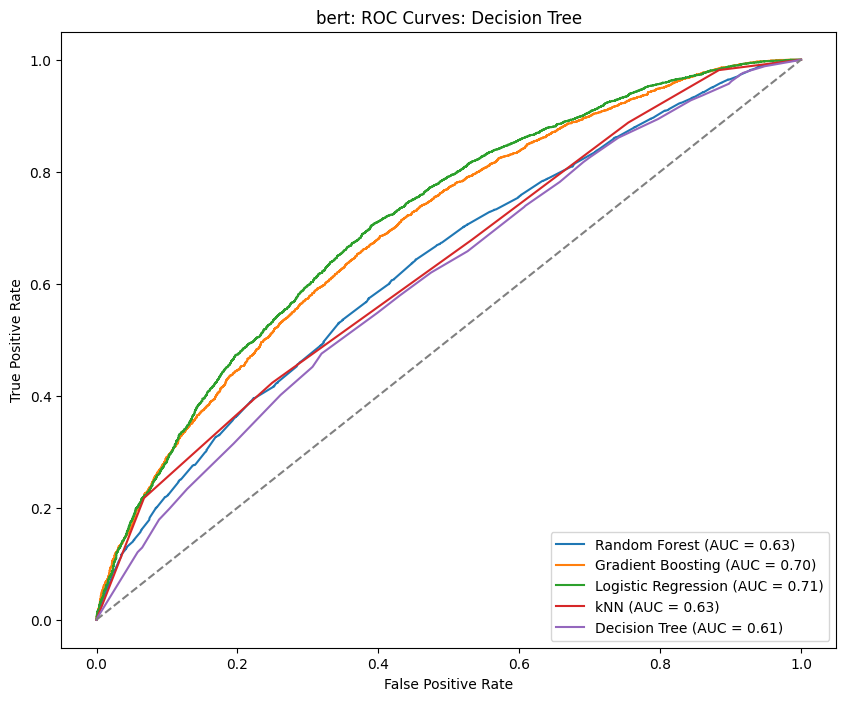

NameError: name 'elmo_embeddings' is not defined

In [ ]:
# TFIDF Matrix
tfidf_model, auc, tfidf_f1, tfidf_fpr, tfidf_tpr = classification_model('TFIDF', TFIDF_embeddings, data['label'])

# doc2vec
doc2vec_model, auc, doc2vec_f1, doc2vec_fpr, doc2vec_tpr =  classification_model('doc2vec', doc2vec_embeddings, data['label'])

# word2vec
word2vec_model, auc, word2vec_f1, word2vec_fpr, word2vec_tpr =  classification_model('word2vec', word2vec_embeddings, data['label'])

# Bert embeddings
bert_model, auc, bert_f1, bert_fpr, bert_tpr = classification_model('bert', bert_embeddings, data['label'])


In [105]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


def classification_model_pca(embedding_name, X, y, n_components=50):  # n_components for PCA
    # Split into training and testing sets
    y = y.apply(convert_labels)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # PCA transformation
    pca = PCA(n_components=n_components)
    
    # Fit PCA on the training data and transform both training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    plt.figure(figsize=(10, 8))

    # dict of models tested
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "kNN": KNeighborsClassifier(n_neighbors=5),
        "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42)
    }

    results = {}
    plt.figure(figsize=(8,6))
    
    # loop over each model
    for name, model in models.items():
        
        # fit the model on the PCA transformed data
        model.fit(X_train_pca, y_train)

        # predict
        y_pred = model.predict(X_test_pca)
        y_proba = model.predict_proba(X_test_pca)[:, 1]
        
        # assessment scores
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        results[name] = {
            'accuracy': acc,
            'auc': auc,
            'f1_score': f1,
            'fpr': fpr,
            'tpr': tpr
        }
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
        print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

    # Find the best model based on AUC
    best_model = max(results, key=lambda x: results[x]['auc'])
    best_fpr = results[best_model]['fpr']
    best_tpr = results[best_model]['tpr']
    best_f1 = results[best_model]['f1_score']
    
    print(f"\n{embedding_name}: Best Model: {best_model} (AUC = {results[best_model]['auc']:.4f})")

    # Plot ROC curves
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.title(f"{embedding_name}: ROC Curves:")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Return best model name, F1 score, FPR, and TPR
    return best_model, best_f1, best_fpr, best_tpr


Random Forest - Accuracy: 0.5126, AUC: 0.4998, F1: 0.5942
Gradient Boosting - Accuracy: 0.5276, AUC: 0.5201, F1: 0.6631
Logistic Regression - Accuracy: 0.5174, AUC: 0.5039, F1: 0.6494
kNN - Accuracy: 0.5037, AUC: 0.5028, F1: 0.5492
Decision Tree - Accuracy: 0.5267, AUC: 0.5171, F1: 0.6520

elmo: Best Model: Gradient Boosting (AUC = 0.5201)


<Figure size 1000x800 with 0 Axes>

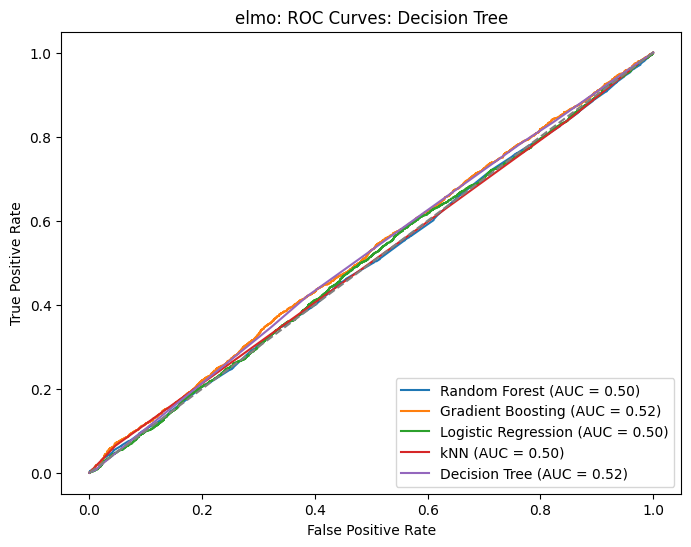

In [134]:
elmo_model, elmo_f1, elmo_fpr, elmo_tpr = classification_model('elmo', elmo_embeddings, data['label'])

Random Forest - Accuracy: 0.5144, AUC: 0.5047, F1: 0.5991
Gradient Boosting - Accuracy: 0.5244, AUC: 0.5102, F1: 0.6654
Logistic Regression - Accuracy: 0.5310, AUC: 0.5120, F1: 0.6782
kNN - Accuracy: 0.5093, AUC: 0.5089, F1: 0.5558
Decision Tree - Accuracy: 0.5214, AUC: 0.5030, F1: 0.6541

elmo: Best Model: Logistic Regression (AUC = 0.5120)


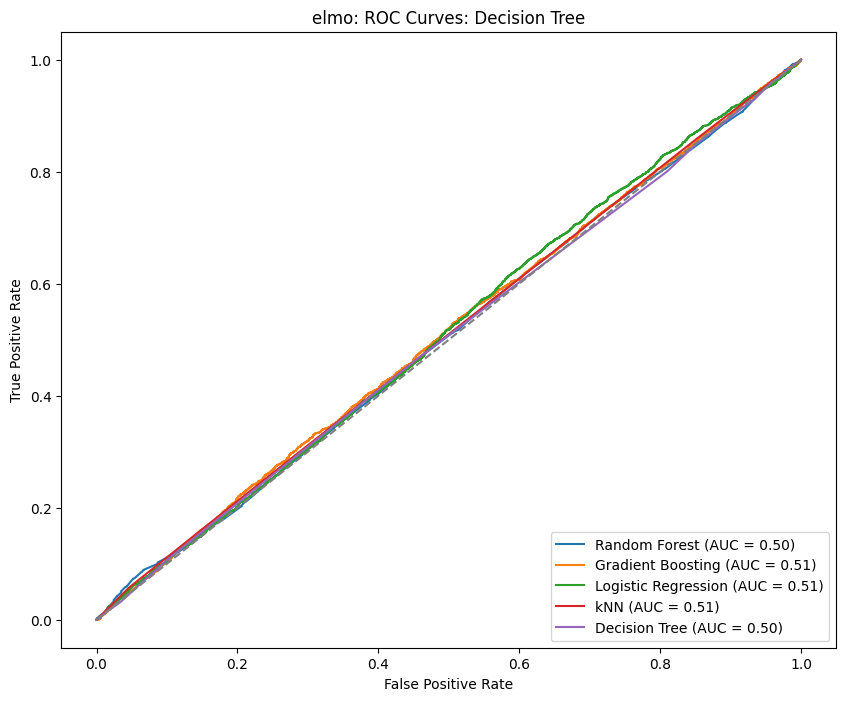

In [103]:
elmo_model, elmo_f1, elmo_fpr, elmo_tpr = classification_model_pca('elmo', elmo_embeddings, data['label'])

Random Forest - Accuracy: 0.5732, AUC: 0.6140, F1: 0.6124
Gradient Boosting - Accuracy: 0.6267, AUC: 0.6802, F1: 0.6587
Logistic Regression - Accuracy: 0.5952, AUC: 0.6489, F1: 0.6507
kNN - Accuracy: 0.5703, AUC: 0.6122, F1: 0.5927
Decision Tree - Accuracy: 0.5912, AUC: 0.6212, F1: 0.5917

TFIDF: Best Model: Gradient Boosting (AUC = 0.6802)


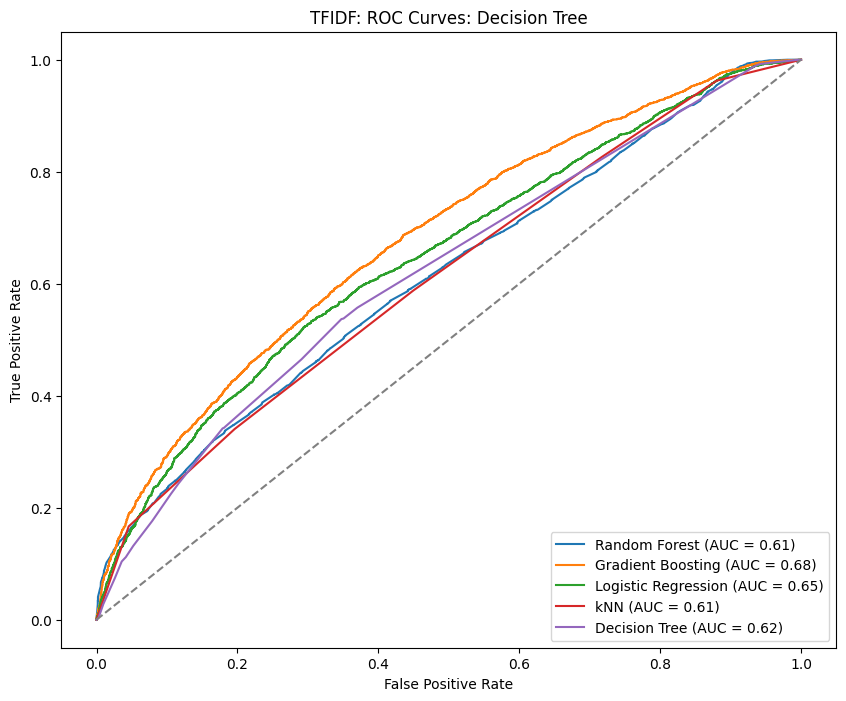

Random Forest - Accuracy: 0.5557, AUC: 0.6055, F1: 0.6080
Gradient Boosting - Accuracy: 0.6074, AUC: 0.6531, F1: 0.6614
Logistic Regression - Accuracy: 0.5921, AUC: 0.6326, F1: 0.6743
kNN - Accuracy: 0.5410, AUC: 0.5773, F1: 0.5821
Decision Tree - Accuracy: 0.5842, AUC: 0.6089, F1: 0.6501

doc2vec: Best Model: Gradient Boosting (AUC = 0.6531)


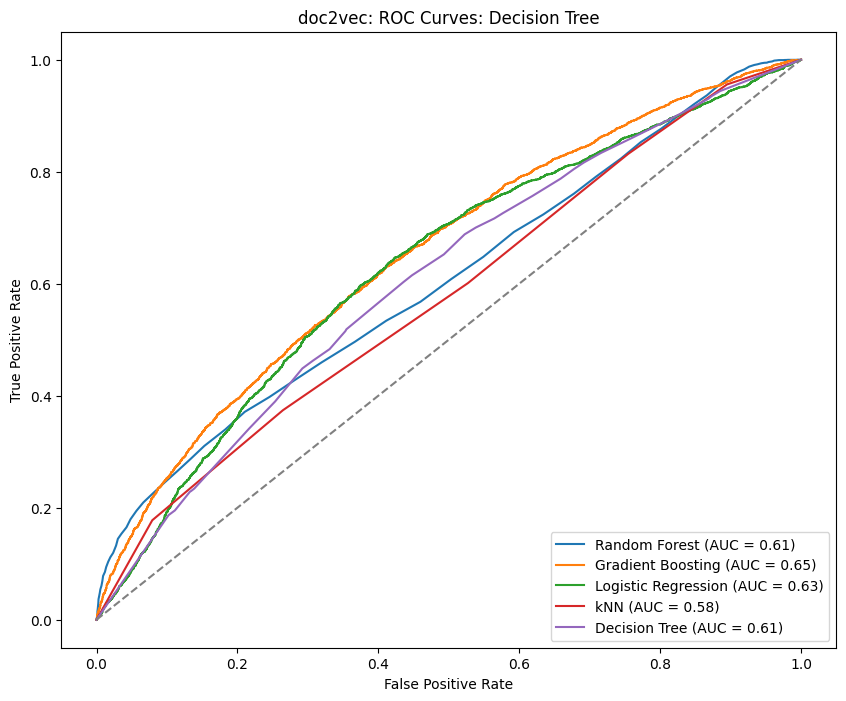

Random Forest - Accuracy: 0.5328, AUC: 0.5772, F1: 0.5902
Gradient Boosting - Accuracy: 0.6155, AUC: 0.6657, F1: 0.6718
Logistic Regression - Accuracy: 0.6079, AUC: 0.6562, F1: 0.6611
kNN - Accuracy: 0.5458, AUC: 0.5822, F1: 0.5885
Decision Tree - Accuracy: 0.5760, AUC: 0.6034, F1: 0.6053

word2vec: Best Model: Gradient Boosting (AUC = 0.6657)


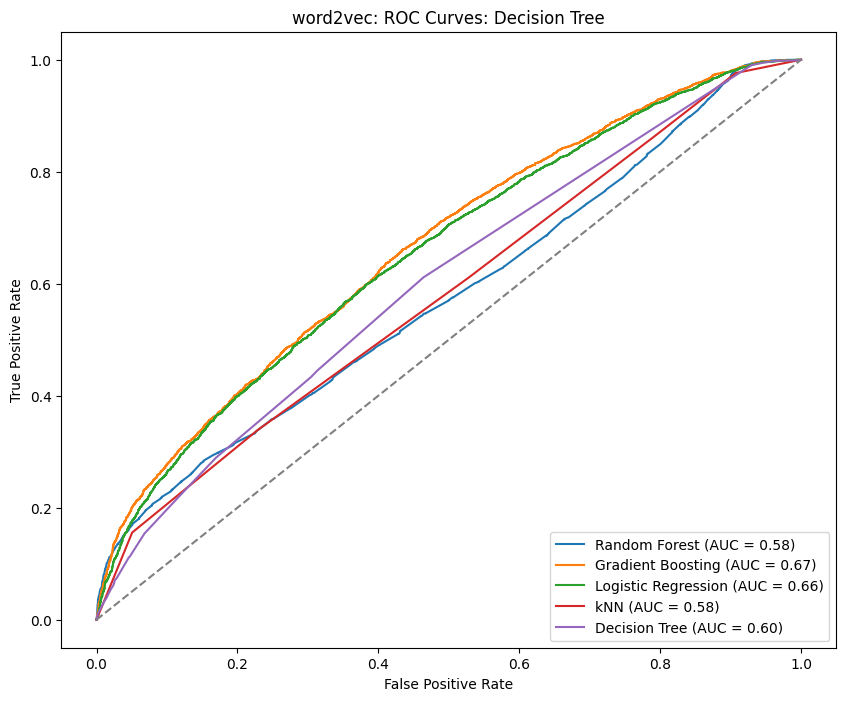

Random Forest - Accuracy: 0.6098, AUC: 0.6518, F1: 0.6607
Gradient Boosting - Accuracy: 0.6466, AUC: 0.6914, F1: 0.6951
Logistic Regression - Accuracy: 0.6326, AUC: 0.6725, F1: 0.6771
kNN - Accuracy: 0.5962, AUC: 0.6402, F1: 0.6318
Decision Tree - Accuracy: 0.6089, AUC: 0.6408, F1: 0.6584

bert: Best Model: Gradient Boosting (AUC = 0.6914)


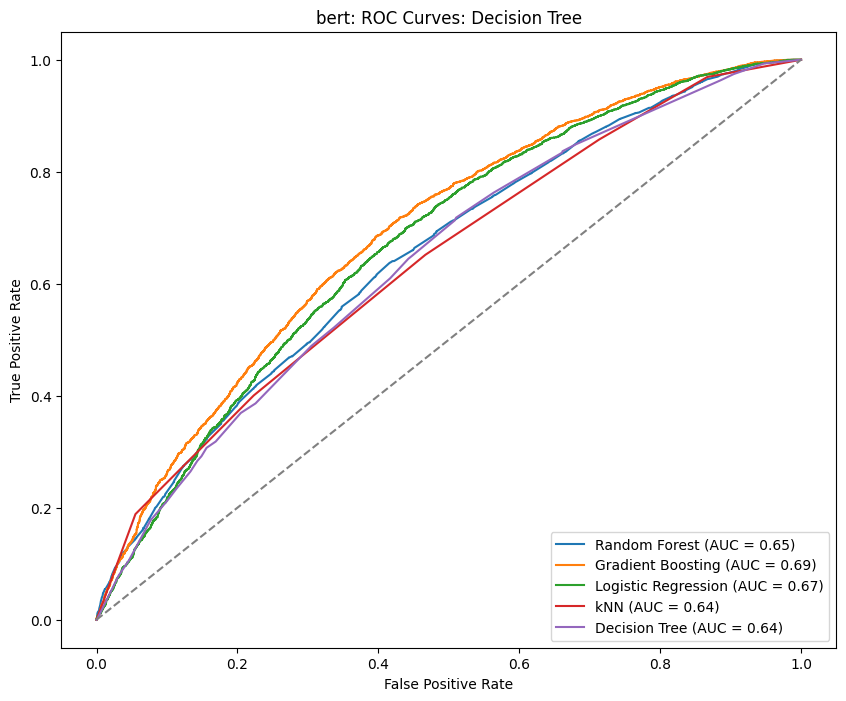

In [101]:
# TFIDF Matrix
tfidf_model, tfidf_f1, tfidf_fpr, tfidf_tpr = classification_model_pca('TFIDF', TFIDF_embeddings, data['label'])

# doc2vec
doc2vec_model, doc2vec_f1, doc2vec_fpr, doc2vec_tpr =  classification_model_pca('doc2vec', doc2vec_embeddings, data['label'])

# word2vec
word2vec_model, word2vec_f1, word2vec_fpr, word2vec_tpr =  classification_model_pca('word2vec', word2vec_embeddings, data['label'])

# Bert embeddings
bert_model, bert_f1, bert_fpr, bert_tpr = classification_model_pca('bert', bert_embeddings, data['label'])


Random Forest - Accuracy: 0.5116, AUC: 0.4960, F1: 0.5974
Gradient Boosting - Accuracy: 0.5281, AUC: 0.5100, F1: 0.6698
Logistic Regression - Accuracy: 0.5306, AUC: 0.5126, F1: 0.6773
kNN - Accuracy: 0.5086, AUC: 0.5083, F1: 0.5540
Decision Tree - Accuracy: 0.5190, AUC: 0.5050, F1: 0.6365

elmo: Best Model: Logistic Regression (AUC = 0.5126)


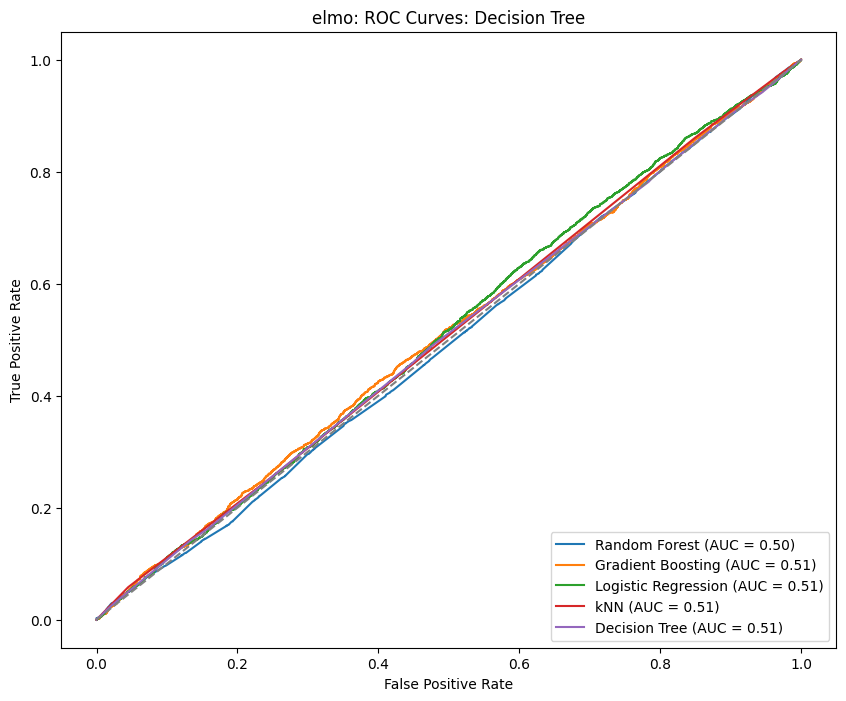

In [102]:
elmo_model, elmo_f1, elmo_fpr, elmo_tpr = classification_model_pca('elmo', elmo_embeddings, data['label'])

## Classifiers with t-SNE

In [149]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


def classification_model_tsne(embedding_name, X, y, n_components=50):  # n_components for PCA
    # Split into training and testing sets
    y = y.apply(convert_labels)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # reduce
    reducer = TSNE(n_components=2, random_state=42, init = 'random')
    X_tsne = reducer.fit_transform(X)

    X_train_tsne, X_test_tsne, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=42)
    
    plt.figure(figsize=(10, 8))

    # dict of models tested
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "kNN": KNeighborsClassifier(n_neighbors=5),
        "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42)
    }

    results = {}
    plt.figure(figsize=(8,6))
    
    # loop over each model
    for name, model in models.items():
        
        # fit the model on the PCA transformed data
        model.fit(X_train_tsne, y_train)

        # predict
        y_pred = model.predict(X_test_tsne)
        y_proba = model.predict_proba(X_test_tsne)[:, 1]
        
        # assessment scores
        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        results[name] = {
            'accuracy': acc,
            'auc': auc,
            'f1_score': f1,
            'fpr': fpr,
            'tpr': tpr
        }
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
        print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1: {f1:.4f}")

    # Find the best model based on AUC
    best_model = max(results, key=lambda x: results[x]['auc'])
    best_fpr = results[best_model]['fpr']
    best_tpr = results[best_model]['tpr']
    best_f1 = results[best_model]['f1_score']
    
    print(f"\n{embedding_name}: Best Model: {best_model} (AUC = {results[best_model]['auc']:.4f})")

    # Plot ROC curves
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line
    plt.title(f"{embedding_name} + tsne ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Return best model name, F1 score, FPR, and TPR
    return best_model, best_f1, best_fpr, best_tpr


Random Forest - Accuracy: 0.3623, AUC: 0.3952, F1: 0.4157
Gradient Boosting - Accuracy: 0.5680, AUC: 0.5793, F1: 0.6832
Logistic Regression - Accuracy: 0.5468, AUC: 0.5500, F1: 0.6854
kNN - Accuracy: 0.4363, AUC: 0.5106, F1: 0.4866
Decision Tree - Accuracy: 0.5691, AUC: 0.5624, F1: 0.6925

TFIDF: Best Model: Gradient Boosting (AUC = 0.5793)


<Figure size 1000x800 with 0 Axes>

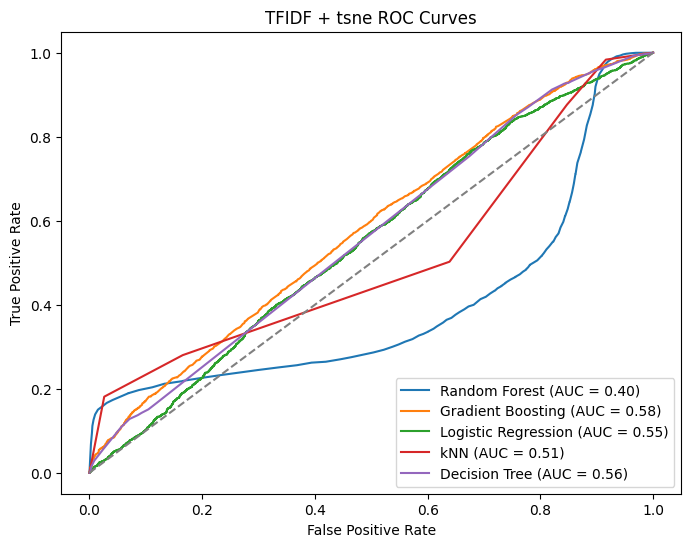

Random Forest - Accuracy: 0.4083, AUC: 0.4131, F1: 0.4577
Gradient Boosting - Accuracy: 0.5656, AUC: 0.5947, F1: 0.6319
Logistic Regression - Accuracy: 0.5555, AUC: 0.5735, F1: 0.6460
kNN - Accuracy: 0.4770, AUC: 0.5249, F1: 0.5257
Decision Tree - Accuracy: 0.5675, AUC: 0.5969, F1: 0.6484

doc2vec: Best Model: Decision Tree (AUC = 0.5969)


<Figure size 1000x800 with 0 Axes>

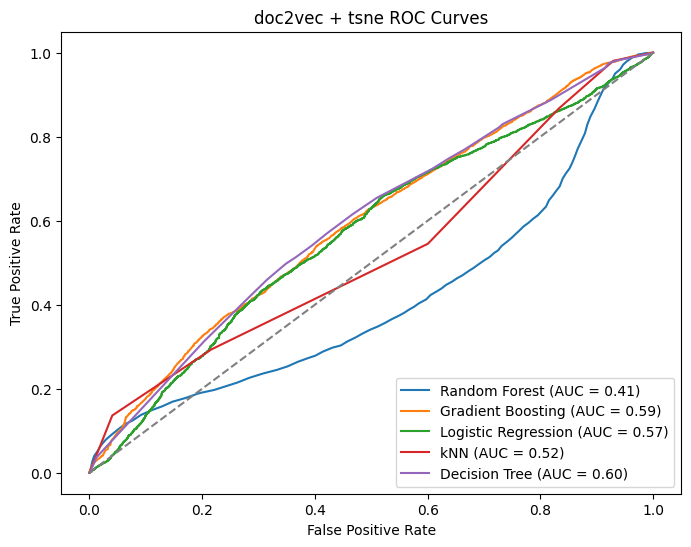

Random Forest - Accuracy: 0.4888, AUC: 0.5234, F1: 0.5297
Gradient Boosting - Accuracy: 0.5803, AUC: 0.6228, F1: 0.6571
Logistic Regression - Accuracy: 0.5761, AUC: 0.6049, F1: 0.6369
kNN - Accuracy: 0.5399, AUC: 0.5792, F1: 0.5792
Decision Tree - Accuracy: 0.5766, AUC: 0.6166, F1: 0.6350

word2vec: Best Model: Gradient Boosting (AUC = 0.6228)


<Figure size 1000x800 with 0 Axes>

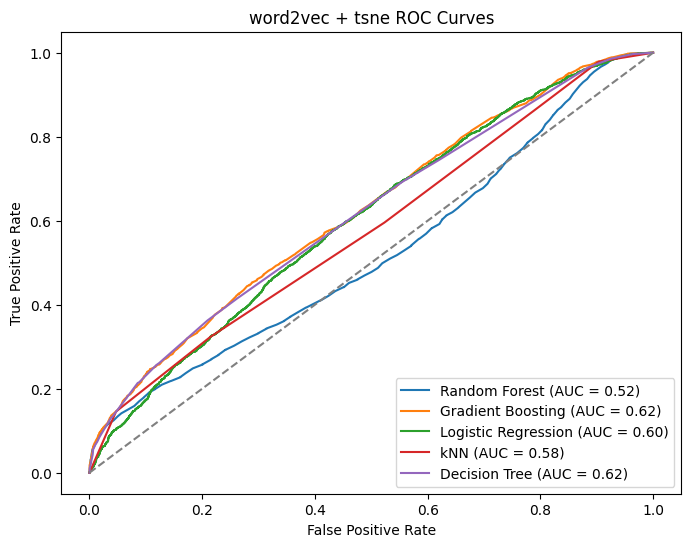

Random Forest - Accuracy: 0.4109, AUC: 0.4572, F1: 0.4609
Gradient Boosting - Accuracy: 0.5838, AUC: 0.6409, F1: 0.6781
Logistic Regression - Accuracy: 0.5493, AUC: 0.5608, F1: 0.6516
kNN - Accuracy: 0.4869, AUC: 0.5619, F1: 0.5312
Decision Tree - Accuracy: 0.5832, AUC: 0.6259, F1: 0.7024

bert: Best Model: Gradient Boosting (AUC = 0.6409)


<Figure size 1000x800 with 0 Axes>

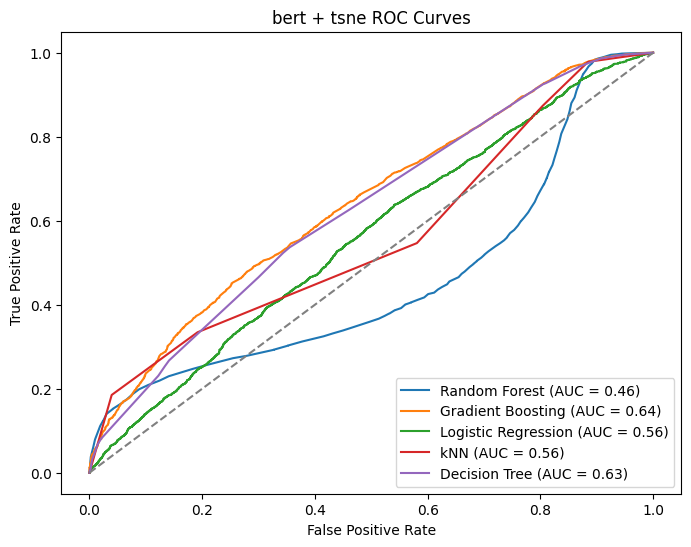

Random Forest - Accuracy: 0.4891, AUC: 0.4882, F1: 0.5305
Gradient Boosting - Accuracy: 0.5274, AUC: 0.5157, F1: 0.6778
Logistic Regression - Accuracy: 0.5317, AUC: 0.5107, F1: 0.6942
kNN - Accuracy: 0.5055, AUC: 0.5056, F1: 0.5535
Decision Tree - Accuracy: 0.5303, AUC: 0.5118, F1: 0.6853

elmo: Best Model: Gradient Boosting (AUC = 0.5157)


<Figure size 1000x800 with 0 Axes>

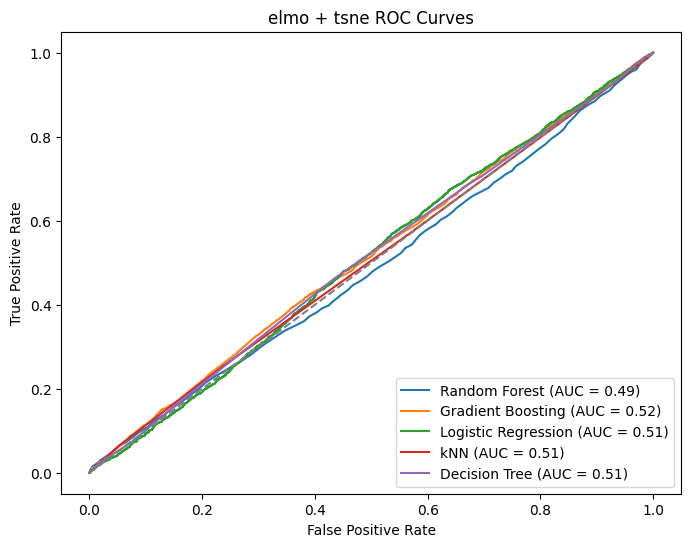

In [150]:
# TFIDF Matrix
tfidf_model, tfidf_f1, tfidf_fpr, tfidf_tpr = classification_model_tsne('TFIDF', TFIDF_embeddings, data['label'])

# doc2vec
doc2vec_model, doc2vec_f1, doc2vec_fpr, doc2vec_tpr =  classification_model_tsne('doc2vec', doc2vec_embeddings, data['label'])

# word2vec
word2vec_model, word2vec_f1, word2vec_fpr, word2vec_tpr =  classification_model_tsne('word2vec', word2vec_embeddings, data['label'])

# Bert embeddings
bert_model, bert_f1, bert_fpr, bert_tpr = classification_model_tsne('bert', bert_embeddings, data['label'])

# elmo
elmo_model, elmo_f1, elmo_fpr, elmo_tpr = classification_model_tsne('elmo', elmo_embeddings, data['label'])

# Compare across all embeddings and reduction

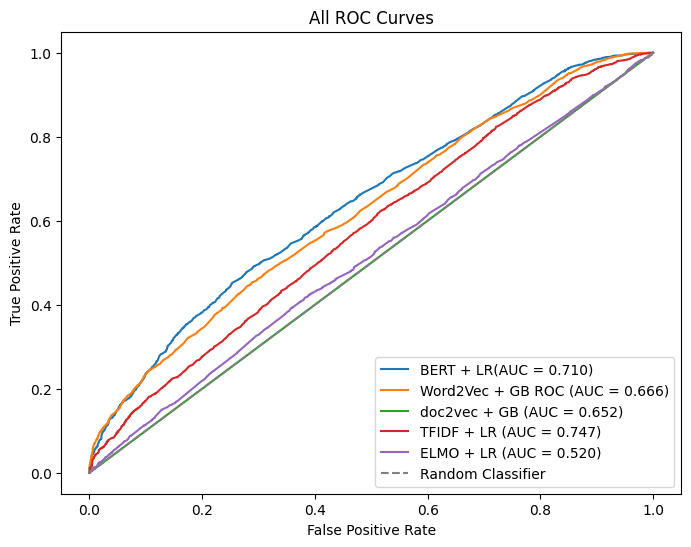

In [152]:
# Plot ROC curves
plt.figure(figsize=(8, 6))

# BERT
plt.plot(bert_fpr, bert_tpr, label=f'BERT + LR(AUC = 0.710)')

# word2vec
plt.plot(word2vec_fpr, word2vec_tpr, label=f'Word2Vec + GB ROC (AUC = 0.666)')

# doc2vec
plt.plot(doc2vec_fpr, doc2vec_fpr, label=f'doc2vec + GB (AUC = 0.652)')

# LR
plt.plot(tfidf_fpr, tfidf_tpr, label=f'TFIDF + LR (AUC = 0.747)')

# Elmo
plt.plot(elmo_fpr, elmo_tpr, label=f'ELMO + LR (AUC = 0.520)')

# Add random classifier line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All ROC Curves')
plt.legend(loc='lower right')

# Show the plot
plt.show()

# Classify New Text

In [59]:
new_data = pd.read_excel('/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/new_hate_df.xlsx')

new_data

Hateful?                                            Comment
0        N  Nobody will care. Nobody watches that shit. Qu...
1        N  I see your treasonous bitch ass wants to get s...
2        N  You’re proud of voting for the guy tanking our...
3        N  Listen up Cheeto Corleone: You run America lik...
4        N                           terrible policy changes 
5        P  Who cares?? You're so America first absolutist...
6        N  You were my preferred airline. There is offici...
7        P  You, girly named dude, woman abusing supporter...
8        P                lets kill jews and eat them for fun

In [153]:
new_data = pd.read_excel('/Users/gracefujinaga/Documents/Northwestern/MSDS_453/MSDS_453/data/new_hate_df.xlsx')

# clean comment
new_data['cleaned_comment'] = new_data['Comment'].apply(clean_comment)
new_data['cleaned_comment_string'] = new_data['cleaned_comment'].apply(lambda x: " ".join(x))

# fit on training data
Tfidf = TfidfVectorizer(ngram_range=(1, 1))
TFIDF_embeddings = Tfidf.fit_transform(data['cleaned_comment_string'].tolist())

# now apply same vectorizor to new test data
TFIDF_embeddings_new = Tfidf.transform(new_data['cleaned_comment_string'].tolist())


# ClUSTER
#cluster_embeddings("tfidf", TFIDF_embeddings_new, n_clusters=2)

def convert_labels(label):
    if label == 'N':
        return 1
    else:
        return 0
    
X_train = TFIDF_embeddings
Y_train = data['label']
Y_train = Y_train.apply(convert_labels)

X_test = TFIDF_embeddings_new
y_test = new_data['Hateful?'].apply(convert_labels)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, Y_train)

# predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)



In [154]:
y_pred

array([0, 1, 0, 0, 0, 1, 0, 1, 1])

In [77]:
new_data

Hateful?                                            Comment  \
0        N  Nobody will care. Nobody watches that shit. Qu...   
1        N  I see your treasonous bitch ass wants to get s...   
2        N  You’re proud of voting for the guy tanking our...   
3        N  Listen up Cheeto Corleone: You run America lik...   
4        N                           terrible policy changes    
5        P  Who cares?? You're so America first absolutist...   
6        N  You were my preferred airline. There is offici...   
7        P  You, girly named dude, woman abusing supporter...   
8        P                lets kill jews and eat them for fun   

                                     cleaned_comment  \
0  [nobodi, care, nobodi, watch, shit, quit, pret...   
1  [see, treason, bitch, ass, want, get, click, l...   
2  [proud, vote, guy, tank, economi, alien, alli,...   
3  [listen, cheeto, corleon, run, america, like, ...   
4                           [terribl, polici, chang]   
5  [care, your, america, first, absolutist, youd,...   
6  [prefer, airlin, offici, zero, reason, fli, fa...   
7  [girli, name, dude, woman, abus, support, advo...   
8                         [let, kill, jew, eat, fun]   

                              cleaned_comment_string  
0    nobodi care nobodi watch shit quit pretend dont  
1  see treason bitch ass want get click let right...  
2  proud vote guy tank economi alien alli caus su...  
3  listen cheeto corleon run america like bit mob...  
4                               terribl polici chang  
5  care your america first absolutist youd root h...  
6  prefer airlin offici zero reason fli fare expe...  
7    girli name dude woman abus support advoc retard  
8                               let kill jew eat fun